In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Required Libraries

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from glob import glob
from PIL import UnidentifiedImageError, Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [5]:
pip install Pillow

ERROR: Operation cancelled by user


In [33]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=413b0b8d51d1c0f2abbdf74150fde037cf19e823c1c95ab3ac3a4675f0427e94
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [6]:
!unzip /content/drive/MyDrive/HV-AI-2024.zip
!rm -rf /content/__MACOSX
!mv /content/HV-AI-2024/* /content/
!rm -rf /content/HV-AI-2024
!rm /content/HV-AI-2024.zip
!rm -rf /content/sample_data
from google.colab import output
output.clear()

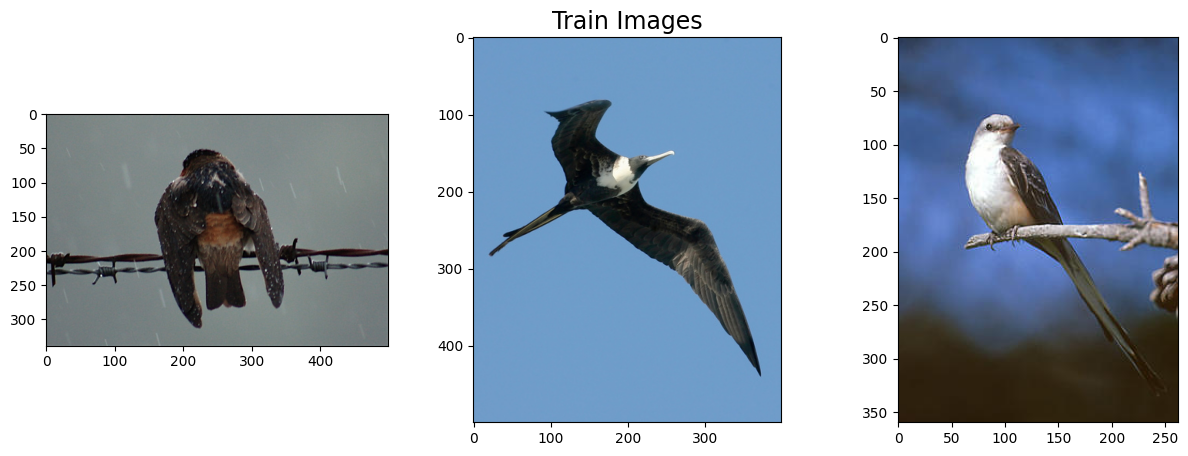

In [7]:
train_images = glob('images/train/*.jpg')[0:3]
test_images = glob('images/test/*.jpg')[0:3]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, image in enumerate(train_images):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)

axes[1].set_title('Train Images',fontsize=17)
plt.show()

Data Loading and Preprocessing

In [8]:
df = pd.read_csv('train.csv')

def check_bbox_validity(row):
    try:
        bbox = list(map(float, row['bbox'].split(' ')))

        if len(bbox) == 4:
            x_min, y_min, x_max, y_max = bbox
            if x_min < x_max and y_min < y_max:
                return True
            else:
                return False
        else:
            return False
    except:
        return False

df['bbox_valid'] = df.apply(check_bbox_validity, axis=1)

df_cleaned = df[df['bbox_valid'] == True].copy()

df_cleaned.drop(columns=['bbox_valid'], inplace=True)

df_cleaned.to_csv('train_cleaned.csv', index=False)

print(f"Original dataset size: {len(df)}")
print(f"Cleaned dataset size: {len(df_cleaned)}")

Original dataset size: 5994
Cleaned dataset size: 4944


In [9]:
df_cleaned = df_cleaned.dropna(subset=['path', 'class', 'bbox'])

In [10]:
def is_image_valid(img_path):
    try:
        img = Image.open(img_path)
        img.verify()
        return True
    except (UnidentifiedImageError, FileNotFoundError, OSError):
        return False

df_cleaned['image_valid'] = df_cleaned['path'].apply(is_image_valid)
df_cleaned = df_cleaned[df_cleaned['image_valid'] == True].copy()
df_cleaned.drop(columns=['image_valid'], inplace=True)

In [11]:
def is_bbox_reasonable(row):
    bbox = list(map(float, row['bbox'].split(' ')))
    x_min, y_min, x_max, y_max = bbox
    width, height = x_max - x_min, y_max - y_min
    if width < 10 or height < 10:
        return False
    if width > 1000 or height > 1000:
        return False
    return True

df_cleaned['bbox_reasonable'] = df_cleaned.apply(is_bbox_reasonable, axis=1)
df_cleaned = df_cleaned[df_cleaned['bbox_reasonable'] == True].copy()
df_cleaned.drop(columns=['bbox_reasonable'], inplace=True)

In [17]:
df_cleaned.to_csv('train_cleaned.csv', index=False)

In [12]:
class_distribution = df_cleaned['class'].value_counts()
with pd.option_context('display.max_rows', None):
    print(class_distribution)

class
104    30
65     30
21     30
64     29
144    29
92     29
99     29
100    28
29     28
28     28
55     28
60     28
83     28
86     28
16     28
109    28
145    28
149    28
63     27
52     27
54     27
184    27
168    27
163    27
159    27
156    27
34     27
69     27
133    27
129    27
128    27
124    27
50     27
0      27
7      27
17     27
25     27
5      27
10     27
33     26
22     26
58     26
61     26
140    26
132    26
70     26
153    26
71     26
122    26
120    26
35     26
106    26
97     26
94     26
56     26
59     26
180    26
174    26
182    26
43     26
6      26
190    26
191    26
48     26
51     26
157    26
2      26
193    25
119    25
194    25
196    25
107    25
93     25
18     25
155    25
179    25
131    25
178    25
142    25
158    25
143    25
8      25
88     25
90     25
199    25
44     25
20     25
49     25
31     25
30     25
67     25
66     25
23     25
62     25
24     24
141    24
121    24
72     24
123    24
12  

Using rsnet50

In [18]:
class BirdDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['path']
        img = Image.open(img_path).convert("RGB")
        label = self.data.iloc[idx]['class']

        if self.transform:
            img = self.transform(img)

        return img, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = BirdDataset(csv_file='train_cleaned.csv', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model = models.resnet50(pretrained=True)

num_bird_species = 200
model.fc = nn.Linear(model.fc.in_features, num_bird_species)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


torch.save(model.state_dict(), 'fine_tuned_resnet50.pth')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Loss: 4.1883, Accuracy: 0.1781
Epoch [2/5], Loss: 2.0561, Accuracy: 0.5935
Epoch [3/5], Loss: 0.9451, Accuracy: 0.8292
Epoch [4/5], Loss: 0.4155, Accuracy: 0.9404
Epoch [5/5], Loss: 0.1673, Accuracy: 0.9869


In [26]:
df_cleaned = pd.read_csv('train_cleaned.csv')

train, validation = train_test_split(df_cleaned, test_size=0.25, random_state=42, stratify=df_cleaned['class'])

print(f"Train set size: {len(train)}")
print(f"Validation set size: {len(validation)}")

train.to_csv('train_split.csv', index=False)
validation.to_csv('validation_split.csv', index=False)

Train set size: 3600
Validation set size: 1200


Keeping epoch under 7 to avoid overfitting

In [45]:
num_epochs = 7
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

torch.save(model.state_dict(), 'fine_tuned_resnet50_7.pth')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/7], Loss: 4.5137, Accuracy: 0.1311
Epoch [2/7], Loss: 2.5704, Accuracy: 0.5022
Epoch [3/7], Loss: 1.3188, Accuracy: 0.7833
Epoch [4/7], Loss: 0.6152, Accuracy: 0.9178
Epoch [5/7], Loss: 0.2774, Accuracy: 0.9800
Epoch [6/7], Loss: 0.1200, Accuracy: 0.9958
Epoch [7/7], Loss: 0.0557, Accuracy: 0.9992


In [46]:
test_dataset = BirdDataset(csv_file='validation_split.csv', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')
    return accuracy

model.load_state_dict(torch.load('fine_tuned_resnet50_7.pth'))
model.to(device)

test_accuracy = evaluate(model, test_loader, device)

<ipython-input-46-a5ca99155a69>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('fine_tuned_resnet50_7.pth'))


Test Accuracy: 0.7025


MODEL 2 - efficientnet

In [36]:
model = EfficientNet.from_pretrained('efficientnet-b0')

num_bird_species = 200
model._fc = nn.Linear(model._fc.in_features, num_bird_species)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

torch.save(model.state_dict(), 'fine_tuned_efficientnet_b0.pth')

Loaded pretrained weights for efficientnet-b0
Epoch [1/10], Loss: 5.1859, Accuracy: 0.0361
Epoch [2/10], Loss: 4.4999, Accuracy: 0.2569
Epoch [3/10], Loss: 3.5717, Accuracy: 0.4072
Epoch [4/10], Loss: 2.7794, Accuracy: 0.5400
Epoch [5/10], Loss: 2.1561, Accuracy: 0.6653
Epoch [6/10], Loss: 1.6674, Accuracy: 0.7597
Epoch [7/10], Loss: 1.2850, Accuracy: 0.8217
Epoch [8/10], Loss: 0.9621, Accuracy: 0.8828
Epoch [9/10], Loss: 0.7396, Accuracy: 0.9150
Epoch [10/10], Loss: 0.5555, Accuracy: 0.9422


In [37]:
model.load_state_dict(torch.load('fine_tuned_efficientnet_b0.pth'))
model.to(device)

test_accuracy = evaluate(model, test_loader, device)

<ipython-input-37-b574b5511d24>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('fine_tuned_efficientnet_b0.pth'))


Test Accuracy: 0.6950


Leveraging bounding box coordinates

In [41]:
class BirdDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['path']
        img = Image.open(img_path).convert("RGB")
        label = self.data.iloc[idx]['class']

        bbox = list(map(float, self.data.iloc[idx]['bbox'].split(' ')))
        x_min, y_min, x_max, y_max = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])

        img = img.crop((x_min, y_min, x_max, y_max))

        if self.transform:
            img = self.transform(img)

        return img, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = BirdDataset(csv_file='train_split.csv', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model = models.resnet50(pretrained=True)

num_bird_species = 200
model.fc = nn.Linear(model.fc.in_features, num_bird_species)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

num_epochs = 7
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

torch.save(model.state_dict(), 'fine_tuned_resnet50_7_bounding_box.pth')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/7], Loss: 4.8552, Accuracy: 0.0733
Epoch [2/7], Loss: 3.3186, Accuracy: 0.3631
Epoch [3/7], Loss: 2.2087, Accuracy: 0.6036
Epoch [4/7], Loss: 1.3740, Accuracy: 0.7931
Epoch [5/7], Loss: 0.7981, Accuracy: 0.9036
Epoch [6/7], Loss: 0.4428, Accuracy: 0.9547
Epoch [7/7], Loss: 0.2345, Accuracy: 0.9814


In [42]:
model.load_state_dict(torch.load('fine_tuned_resnet50_7_bounding_box.pth'))
model.to(device)

test_accuracy = evaluate(model, test_loader, device)

<ipython-input-42-8f39a8acb4ad>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('fine_tuned_resnet50_7_bounding_box.pth'))


Test Accuracy: 0.4933


Running test dataset on various models

In [58]:
class BirdDatasetTest(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['path']
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, img_path

test_dataset = BirdDatasetTest(csv_file='test.csv', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = models.resnet50(pretrained=False)
num_bird_species = 200
model.fc = nn.Linear(model.fc.in_features, num_bird_species)
model.load_state_dict(torch.load('fine_tuned_resnet50_10.pth'))  # Load the trained weights
model.to(device)
model.eval()

predictions = []

with torch.no_grad():
    for images, img_paths in test_loader:
        images = images.to(device)

        outputs = model(images)

        probabilities = F.softmax(outputs, dim=1)
        confidence_scores, predicted_labels = torch.max(probabilities, 1)

        for img_path, predicted_label, confidence_score in zip(img_paths, predicted_labels, confidence_scores):
            predictions.append({
                'path': img_path,
                'predicted_label': predicted_label.item(),
                'confidence_score': confidence_score.item()
            })

predictions_df = pd.DataFrame(predictions)

predictions_df.to_csv('/content/predictions.csv', index=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-58-5ba489a9070c>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

In [59]:
import requests

def send_results_for_evaluation(name, csv_file, email):
    url = "http://43.205.49.236:5050/inference"
    files = {'file': open(csv_file, 'rb')}
    data = {'email': email, 'name':name}
    response = requests.post(url, files=files, data=data)
    return response.json()

print('Accuracy: ')
print(send_results_for_evaluation('Animesh Seth', '/content/predictions.csv', 'animesh.seth2021@vitstudent.ac.in'))

Accuracy: 
{'overall_accuracy (%)': 70.02071, 'max_accuracy_class': 133, 'max_accuracy (%)': 100.0, 'min_accuracy_class': 29, 'min_accuracy (%)': 13.33333}
